Mounting Google Drive...
Mounted at /content/drive

--- Copying 'images_balanced_4200' to local Colab disk ---
    331,699,475 100%    3.55MB/s    0:01:28 (xfr#4200, to-chk=0/4201)

--- Local copy complete in 106.65 seconds ---

Loading CSV from: /content/drive/MyDrive/Pneumonia_Advanced_Project/2_processed_data/master_labels_balanced.csv
Preparing data and re-creating test split...
Labels found (6): ['COVID-19' 'Lung Opacity' 'Normal' 'Pneumonia (Bacterial)'
 'Pneumonia (Viral)' 'Tuberculosis']
Successfully re-created test set with 630 images.
Building tf.data pipeline for the test set...
Test pipeline built.
Loading saved model from: /content/drive/MyDrive/Pneumonia_Advanced_Project/4_models/v1_image_model.h5


Model loaded successfully.

Making predictions on the full test set...
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 430ms/step
Generating Confusion Matrix...

Confusion matrix plot saved to: /content/drive/MyDrive/Pneumonia_Advanced_Project/4_models/v1_confusion_matrix.png


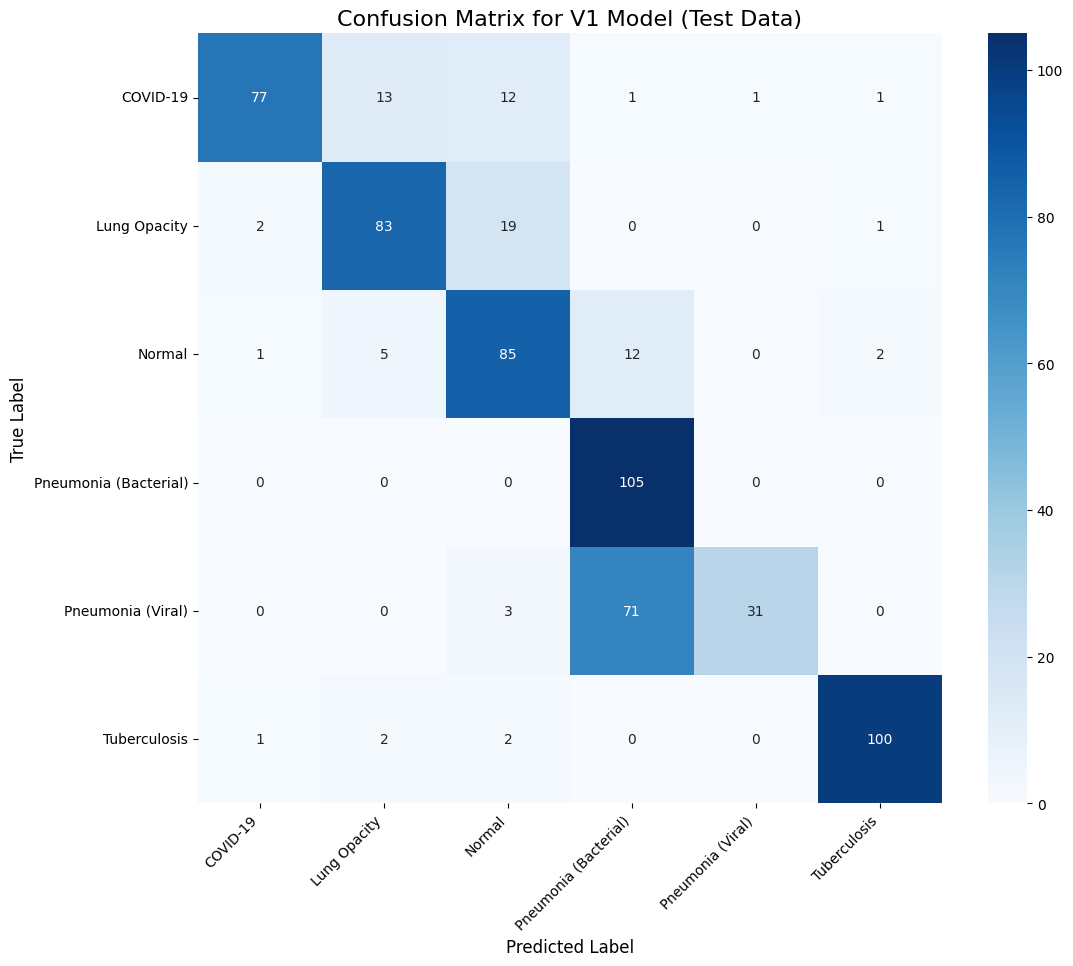


--- Classification Report (Test Data) ---
                       precision    recall  f1-score   support

             COVID-19       0.95      0.73      0.83       105
         Lung Opacity       0.81      0.79      0.80       105
               Normal       0.70      0.81      0.75       105
Pneumonia (Bacterial)       0.56      1.00      0.71       105
    Pneumonia (Viral)       0.97      0.30      0.45       105
         Tuberculosis       0.96      0.95      0.96       105

             accuracy                           0.76       630
            macro avg       0.82      0.76      0.75       630
         weighted avg       0.82      0.76      0.75       630


--- Process Complete ---


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from google.colab import drive
import shutil
import time
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

# --- 1. Mount Drive and Define Paths ---
print("Mounting Google Drive...")
drive.mount('/content/drive', force_remount=True)

# --- Define Your Project Paths ---
BASE_DIR = "/content/drive/MyDrive/Pneumonia_Advanced_Project/"
# This is your new, clean folder with 4,200 images
DRIVE_IMAGE_DIR = os.path.join(BASE_DIR, "2_processed_data", "images_balanced_4200")
CSV_PATH = os.path.join(BASE_DIR, "2_processed_data", "master_labels_balanced.csv")
MODEL_PATH = os.path.join(BASE_DIR, "4_models", "v1_image_model.h5")
LOCAL_IMAGE_DIR = "/content/local_images" # The fast local disk

# --- 2. Copy Data From Drive to Local Colab Disk ---
print(f"\n--- Copying '{os.path.basename(DRIVE_IMAGE_DIR)}' to local Colab disk ---")
if os.path.exists(LOCAL_IMAGE_DIR):
    print(f"'{LOCAL_IMAGE_DIR}' already exists. Deleting it for a fresh copy.")
    shutil.rmtree(LOCAL_IMAGE_DIR)

start_time = time.time()
!rsync -a --info=progress2 "{DRIVE_IMAGE_DIR}/" "{LOCAL_IMAGE_DIR}/"
end_time = time.time()
print(f"\n--- Local copy complete in {end_time - start_time:.2f} seconds ---")

# --- 3. Load CSV and Re-Create the Test Set ---
print(f"\nLoading CSV from: {CSV_PATH}")
df = pd.read_csv(CSV_PATH)
print("Preparing data and re-creating test split...")

# a) Re-create LabelEncoder
# This is crucial: it must be in the same alphabetical order as before
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])
class_labels = label_encoder.classes_
print(f"Labels found ({len(class_labels)}): {class_labels}")

# b) Add the local filepaths
df['filepath'] = df['filename'].apply(lambda x: os.path.join(LOCAL_IMAGE_DIR, x))

# c) Re-create the *exact* same splits using the same random_state
# This guarantees we get the identical test_df
train_val_df, test_df = train_test_split(
    df,
    test_size=0.15, # 15% for test set
    random_state=42,
    stratify=df['label_encoded']
)
# (We don't need train_df or val_df, only test_df)
print(f"Successfully re-created test set with {len(test_df)} images.")

# --- 4. Build the tf.data Pipeline for the Test Set ---
print("Building tf.data pipeline for the test set...")
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 6
AUTOTUNE = tf.data.AUTOTUNE

def load_and_preprocess(filepath, label):
    image = tf.io.read_file(filepath)
    image = tf.io.decode_image(image, channels=3, expand_animations=False)
    image = tf.image.resize(image, [IMG_SIZE[0], IMG_SIZE[1]])
    image = tf.cast(image, tf.float32) / 255.0
    label = tf.one_hot(label, depth=NUM_CLASSES)
    return image, label

# Create the test dataset
test_ds = tf.data.Dataset.from_tensor_slices(
    (test_df['filepath'].values, test_df['label_encoded'].values)
)
test_ds = (
    test_ds
    .map(load_and_preprocess, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=AUTOTUNE)
)
print("Test pipeline built.")

# --- 5. Load the Model ---
print(f"Loading saved model from: {MODEL_PATH}")
if not os.path.exists(MODEL_PATH):
    print(f"--- ERROR: Model file not found at {MODEL_PATH} ---")
else:
    best_model = tf.keras.models.load_model(MODEL_PATH)
    print("Model loaded successfully.")

    # --- 6. Run Predictions and Generate Confusion Matrix ---
    print("\nMaking predictions on the full test set...")
    y_pred_probs = best_model.predict(test_ds)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)

    # Get the true labels
    y_true = test_df['label_encoded'].values

    print("Generating Confusion Matrix...")
    cm = confusion_matrix(y_true, y_pred_classes)

    # Plot the Confusion Matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d', # Format as integers
        cmap='Blues',
        xticklabels=class_labels,
        yticklabels=class_labels
    )
    plt.title('Confusion Matrix for V1 Model (Test Data)', fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)

    # Save the plot
    cm_plot_path = os.path.join(BASE_DIR, "4_models", "v1_confusion_matrix.png")
    plt.savefig(cm_plot_path)
    print(f"\nConfusion matrix plot saved to: {cm_plot_path}")
    plt.show()

    # --- 7. Print Classification Report ---
    print("\n--- Classification Report (Test Data) ---")
    print(classification_report(y_true, y_pred_classes, target_names=class_labels))

print("\n--- Process Complete ---")